In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import multiprocessing as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from operator import xor

In [3]:
from classifier import *
from ntk import *
from Q_minimization import *
from train import *

### Define Dimensions

In [4]:
n = 5
d = 3

### Define Dataset

In [122]:
x = np.array([[1, -0.8, -0.5], [1, -0.4, -0.5], [1, 0.15, 0.3]])
y = np.array([[1.0, -1.0, 1.0]]).reshape(-1,)
dataset = '3PTS'

### Solve L1

In [123]:
u_0 = np.random.normal(loc=0, scale=1, size=(d,))
v_0 = np.random.normal(loc=0, scale=1, size=(d,))

In [124]:
u_opt_L1, v_opt_L1 = solver(x, y, u_0, v_0, d, obj='L1')
u_opt_L1, v_opt_L1

(array([ 0.17685289, -2.23606523,  2.43643762]),
 array([-0.17670049,  2.23607054,  2.4369594 ]))

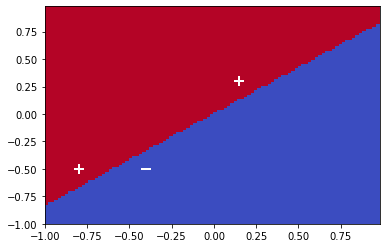

In [125]:
plot_classifier(u_opt_L1, v_opt_L1, x, y)

In [126]:
w_tilde_L1 = calc_w_tilde(u_opt_L1, v_opt_L1)
w_tilde_L1

array([-0.03124999, -4.9999996 ,  5.93749955])

In [127]:
np.linalg.norm(w_tilde_L1, ord=1)

10.968749145924527

In [128]:
minimal_margin(u_opt_L1, v_opt_L1, x, y)

0.9999999103671571

In [129]:
normalized_margins(u_opt_L1, v_opt_L1, x, y)

array([1.        , 1.00000002, 1.00000002])

### Empirical Gradient Flow

In [120]:
x.transpose()

array([[ 1.  ,  1.  ,  1.  ,  1.  ],
       [-0.8 , -0.4 ,  0.15,  0.35],
       [-0.5 , -0.5 ,  0.3 ,  0.6 ]])

In [121]:
np.dot(np.multiply(u_0, v_0).transpose(), x.transpose())

array([-0.3 ,  0.1 ,  1.45,  1.95])

In [52]:
update(u_0, v_0, x, y, step_size=1)

[-0.38014594 -0.3381302   0.0204232 ]
[-0.12671531 -0.11271007  0.00680773]


(array([-0.95749621,  0.23922007,  0.59777347]),
 array([-1.85876612,  1.61934074,  1.73885854]),
 0.3453556476709357,
 -0.3)

In [38]:
grad_r = np.array([ 0.47666625, -0.39026132,  0.08283217,  0.05024025])

In [39]:
np.matmul(x.transpose(), grad_r) 

array([ 0.21947735, -0.19521956,  0.01179134])

In [40]:
np.multiply(np.matmul(x.transpose(), grad_r), v_0)

array([-0.01834669,  0.22758354,  0.00197855])

In [41]:
x.transpose()

array([[ 1.  ,  1.  ,  1.  ,  1.  ],
       [-0.8 , -0.4 ,  0.15,  0.35],
       [-0.5 , -0.5 ,  0.3 ,  0.6 ]])

In [ ]:
update(u, v, x, y, step_size)

In [119]:
np.multiply(u_0, v_0).transpose()

array([1., 1., 1.])

In [118]:
u_0, v_0 = init_weights(alpha=[1]*d, s=get_s_from_s_val(0.5), d=d, same_sign=True)
u_0, v_0

(array([ 0.57735027,  0.57735027, -0.57735027]),
 array([ 1.73205081,  1.73205081, -1.73205081]))

In [46]:
def update(u, v, x, y, step_size):
	n, d = x.shape

	y_pred = np.dot(np.multiply(u, v).transpose(), x.transpose())
	margins = np.multiply(y, y_pred)
	gamma = np.min(margins)

	temp = np.exp(gamma - margins)
	grad_r = np.multiply(temp, y) / np.sum(temp)

	u_grad = np.multiply(np.matmul(x.transpose(), grad_r), v)
	v_grad = np.multiply(np.matmul(x.transpose(), grad_r), u)
	print(u_grad)
	print(v_grad)
	u = u + step_size * u_grad
	v = v + step_size * v_grad
	gamma_tilde = gamma - np.log(np.sum(temp) / n)
	return u, v, gamma_tilde, gamma

In [130]:
def get_s_from_s_val(s_val):
    return [s_val] * d

In [152]:
def train_worker(alpha, s_val, d):
    u_0, v_0 = init_weights(alpha=alpha, s=get_s_from_s_val(s_val), d=d, same_sign=True)
    
    results = {}
    results[s_val] = train(
        u_0=u_0,
        v_0=v_0,
        x=x,
        y=y,
        step_size=1e-5,
        n_epochs=5000000,
        eval_freq=1000)
    
    results[s_val].update({'u_0': u_0, 'v_0': v_0})
    return results

In [164]:
alpha = [100] * d
s_vals = [0.001, 0.5, 0.95, 0.999]

In [165]:
pool = mp.Pool(processes=len(s_vals))
pool_output = [pool.apply_async(train_worker, args=(alpha, s_val, d)) for s_val in s_vals]
results = {}
[results.update(p_out.get()) for p_out in pool_output]

100%|██████████| 5000000/5000000 [03:06<00:00, 26767.95it/s]


[None, None, None, None]

In [166]:
def downsample_results(res_dict, sample_freq=10, start_from=1000, excluded_keys=['u_0', 'v_0']):
    res_dict_downsampled = {}
    for k, v in res_dict.items():
        if not isinstance(v, dict):
            raise NotImplementedError('Expected nested results dict.')
        
        res_dict_downsampled[k] = {}
        for k_v, v_v in v.items():
            if k_v in excluded_keys:
                res_dict_downsampled[k][k_v] = v_v
            else:
                res_dict_downsampled[k][k_v] = v_v[:start_from] + v_v[start_from::sample_freq]
    return res_dict_downsampled

In [167]:
# downsample results
results_GD = downsample_results(results)

In [168]:
np.save(f'../results/uv__GD_{dataset}_alpha_{alpha[0]}.npy',  results_GD) 

In [169]:
# results_GD_restored = np.load('../results/GD_COLT_A_alpha_100_m_20.npy', allow_pickle=True)
# results_GD = results_GD_restored[()]

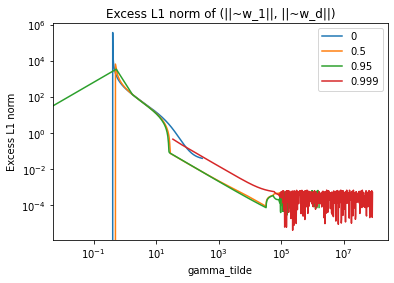

In [170]:
for k, res in results_GD.items():
    if k not in [0.001, 0.5, 0.95, 0.999]:
        continue
    plot(
        [t for t in res['training_loss']],
        [np.linalg.norm(calc_w_tilde(u, v), ord=1) / gamma - np.linalg.norm(w_tilde_L1, ord=1) 
         for u, v, gamma in zip(res['u'], res['v'], res['minimal_margin'])],
        '')

yscale('log')
xscale('log')
ylabel('Excess L1 norm')
xlabel('gamma_tilde');
title(f'Excess L1 norm of (||~w_1||, ||~w_d||)');
legend([0, 0.5, 0.95, 0.999]);

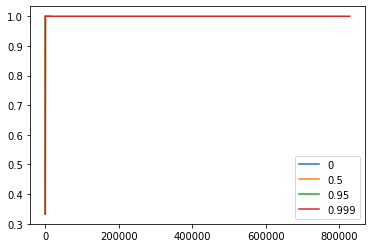

In [160]:
for k, res in results_GD.items():
    if k not in [0.001, 0.5, 0.95, 0.999]:
        continue
    plot(
        [t for t in res['training_loss']],
        [t for t in res['training_accuracy']],
        '')
legend([0, 0.5, 0.95, 0.999]);

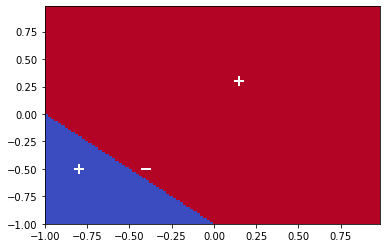

In [161]:
plot_classifier(results_GD[0.95]['u_0'], results_GD[0.95]['v_0'], x, y)

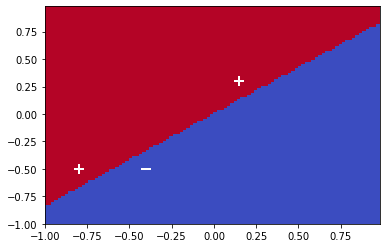

In [173]:
plot_classifier(results_GD[0.5]['u'][-1], results_GD[0.5]['v'][-1], x, y)

### S.V stability

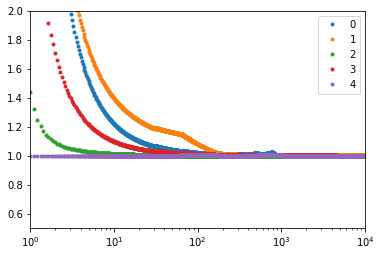

In [119]:
res_GD = results_GD[0]

for idx in range(len(x)):
    plot(
        [t for t in res_GD['training_loss']],
        [normalized_margins(u, v, x, y)[idx] for t, w, a in zip(res_GD['training_loss'], res_GD['u'], res_GD['v'])],
        '.')
ylim([0.5, 2])
xlim([1, alpha[0]**2])
xscale('log')
legend(list(range(len(x))))

### Estimate Q Minimization

In [175]:
def run_Q_minimization(alpha, s, w_0, a_0):
    mu_Q = []
    w_array_Q = []
    a_array_Q = []

    for mu_val in tqdm([1e-4, 1e-3, 0.01, 0.1, 0.5, 1, 2, 5, 10, 25, 50, 100, 200, 300, 400, 500, 1000]):
        mu = [mu_val] * m

        NUM_RERIES = 5
        best_Q_val_so_far = np.inf

        for retry in range(NUM_RERIES):
            try:
                w_opt_Q, a_opt_Q = solver(
                    x,
                    y,
                    w_0,
                    a_0,
                    m,
                    d,
                    obj='Q',
                    mu=mu,
                    s=s,
                    x0=np.random.normal(size=(m * (d + 1),)),
                    optim_tol=1e-4
                )

                Q_val = Q_func(w_opt_Q, a_opt_Q, mu, s)
                if (Q_val < best_Q_val_so_far):
                    best_Q_val_so_far = Q_val
                    w_best_Q = w_opt_Q
                    a_best_Q = a_opt_Q

            except Exception as e:
                print(f'Mu = {mu[0]}:: {e}')            

        mu_Q.append(mu_val)
        w_array_Q.append(w_best_Q)
        a_array_Q.append(a_best_Q)
    
    return {
        'mu': mu_Q,
        'w': w_array_Q,
        'a': a_array_Q
    }

In [176]:
def Q_min_worker(alpha, s_val, m, d):
    s = get_s_from_s_val(s_val)
    w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=True)
    
    return {s_val: run_Q_minimization(alpha, s, w_0, a_0)}

In [177]:
pool = mp.Pool(processes=len(s_vals))
pool_output = [pool.apply_async(Q_min_worker, args=(alpha, s_val, m, d)) for s_val in s_vals]
results_Q = {}
[results_Q.update(p_out.get()) for p_out in pool_output]

100%|██████████| 17/17 [04:58<00:00, 17.55s/it]


[None, None, None, None, None, None, None]

In [178]:
np.save(f'../results/Q_dataset_{dataset}_alpha_{alpha[0]}_m_{m}.npy',  results_Q) 

In [52]:
# results_Q_restored = np.load('../results/Q_dataset_COLT_A_alpha_100_m_20.npy', allow_pickle=True)
# results_Q = results_Q_restored[()]

#### Plot Q - GD match

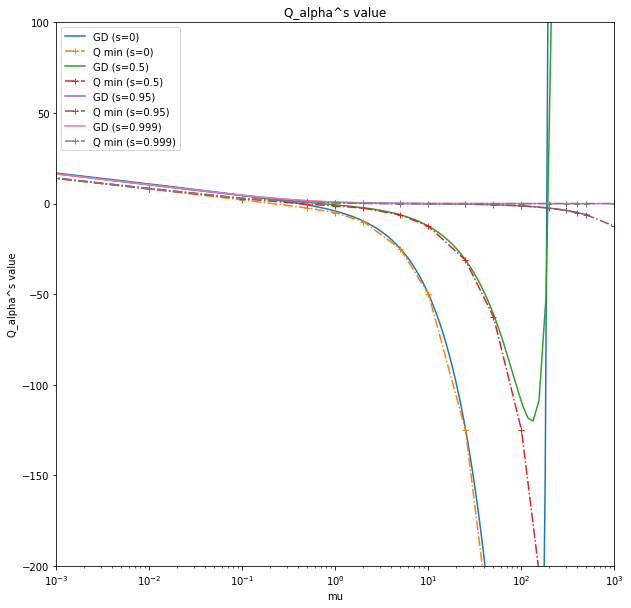

In [54]:
s_vals_to_draw = [0, 0.5, 0.95, 0.999]
legend_ = []

plt.figure(figsize=[10, 10])
for s_val in s_vals_to_draw:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]

    plot(
        [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']],
        [Q_func(w / minimal_margin(w, a, x, y), a.reshape(-1, 1), [2 * alpha[0]/(1 - s_val**2)/t] * m, s)
         for t, w, a in zip(res_GD['training_loss'], res_GD['w'], res_GD['a'])],
        '')

    plot(
        [mu_val for mu_val in res_Q['mu']],
        [Q_func(w, a.reshape(-1, 1), [mu_val] * m, s) 
         for mu_val, w, a in zip(res_Q['mu'], res_Q['w'], res_Q['a'])],
        '-.+')

    legend_.extend([f'GD (s={s_val})', f'Q min (s={s_val})'])
    

ylim([-200, 100])
xlim([1e-3, 1e3])
xscale('log')
ylabel('Q_alpha^s value')
xlabel('mu');
title(f'Q_alpha^s value');
legend(legend_);

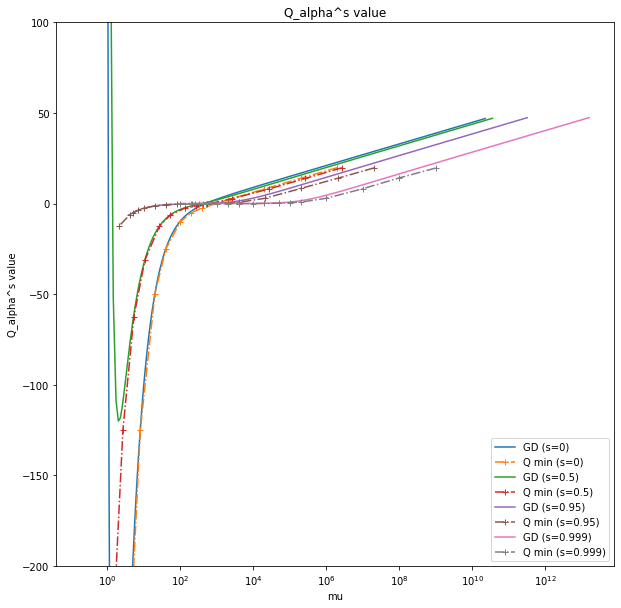

In [127]:
s_vals_to_draw = [0, 0.5, 0.95, 0.999]
legend_ = []

plt.figure(figsize=[10, 10])
for s_val in s_vals_to_draw:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]

    plot(
        [t for t in res_GD['training_loss']],
        [Q_func(w / minimal_margin(w, a, x, y), a.reshape(-1, 1), [2 * alpha[0]/(1 - s_val**2)/t] * m, s)
         for t, w, a in zip(res_GD['training_loss'], res_GD['w'], res_GD['a'])],
        '')

    plot(
        [(2 * alpha[0])/(1 - s_val**2)/mu_val for mu_val in res_Q['mu']],
        [Q_func(w, a.reshape(-1, 1), [mu_val] * m, s) 
         for mu_val, w, a in zip(res_Q['mu'], res_Q['w'], res_Q['a'])],
        '-.+')

    legend_.extend([f'GD (s={s_val})', f'Q min (s={s_val})'])
    

ylim([-200, 100])
#xlim([1e-3, 1e3])
xscale('log')
ylabel('Q_alpha^s value')
xlabel('mu');
title(f'Q_alpha^s value');
legend(legend_);

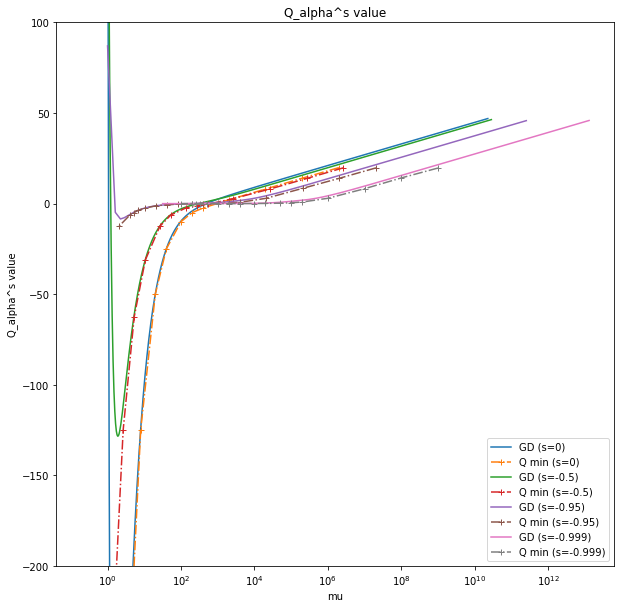

In [128]:
s_vals_to_draw = [0, -0.5, -0.95, -0.999]
legend_ = []

plt.figure(figsize=[10, 10])
for s_val in s_vals_to_draw:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]

    plot(
        [t for t in res_GD['training_loss']],
        [Q_func(w / minimal_margin(w, a, x, y), a.reshape(-1, 1), [2 * alpha[0]/(1 - s_val**2)/t] * m, s)
         for t, w, a in zip(res_GD['training_loss'], res_GD['w'], res_GD['a'])],
        '')

    plot(
        [(2 * alpha[0])/(1 - s_val**2)/mu_val for mu_val in res_Q['mu']],
        [Q_func(w, a.reshape(-1, 1), [mu_val] * m, s) 
         for mu_val, w, a in zip(res_Q['mu'], res_Q['w'], res_Q['a'])],
        '-.+')

    legend_.extend([f'GD (s={s_val})', f'Q min (s={s_val})'])
    

ylim([-200, 100])
#xlim([1e-3, 1e3])
xscale('log')
ylabel('Q_alpha^s value')
xlabel('mu');
title(f'Q_alpha^s value');
legend(legend_);

### Plot NTK kerel change over time

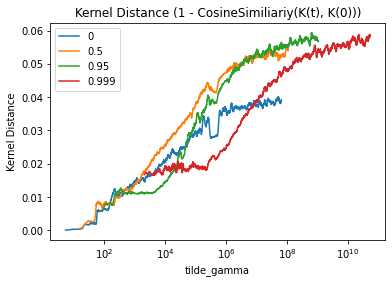

In [181]:
for k, res in results_GD.items():
    if k not in [0, 0.5, 0.95, 0.999]:
        continue

    kernel_distances_smooth = pd.Series(res['kernel_distances']).rolling(50).mean()
    plot([t for t in res['training_loss']], kernel_distances_smooth)

xscale('log')
ylabel('Kernel Distance')
xlabel('tilde_gamma');
title(f'Kernel Distance (1 - CosineSimiliariy(K(t), K(0)))');
legend([0, 0.5, 0.95, 0.999])

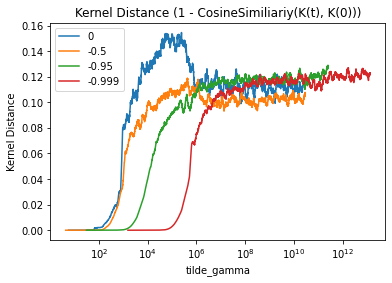

In [79]:
for k, res in results_GD.items():
    if k not in [0, -0.5, -0.95, -0.999]:
        continue

    kernel_distances_smooth = pd.Series(res['kernel_distances']).rolling(50).mean()
    plot([t for t in res['training_loss']], kernel_distances_smooth)

xscale('log')
ylabel('Kernel Distance')
xlabel('tilde_gamma');
title(f'Kernel Distance (1 - CosineSimiliariy(K(t), K(0)))');
legend([0, -0.5, -0.95, -0.999])

### Second Layer sign switches

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


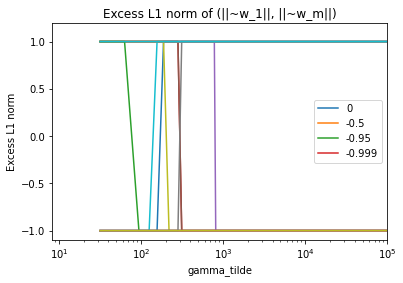

In [103]:
for k, res in results_GD.items():
    if k not in [-0.999]:
        continue
    plot(
        [t for t in res['training_loss']],
        [np.sign(a.reshape(-1,)) for a in res['a']],
        '')

xscale('log')
xlim([0, 1e5])
ylim([-1.1, 1.2])
ylabel('Excess L1 norm')
xlabel('gamma_tilde');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend([0, -0.5, -0.95, -0.999]);

##### Plot decision boundary over time

In [472]:
s_val = 0.999
res_GD = results_GD[s_val]

In [473]:
mu_vals = [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']]
print('mu range:' ,max(mu_vals), min(mu_vals))
print('gamma_tilde range:', min(res_GD['training_loss']), max(res_GD['training_loss']))

mu range: 1014.7499560021764 6.264615185406635e-09
gamma_tilde range: 98.59574215373803 15970657742166.389


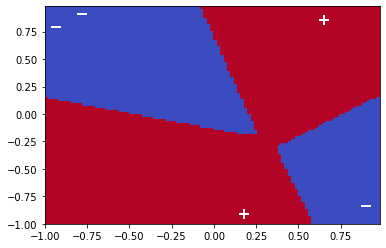

In [474]:
plot_classifier(res_GD['w'][-1], res_GD['a'][-1], x, y)

tilde_gamma=98.59574215373803, mu = 1014.7499560021764, min margin = 97.84911781819048


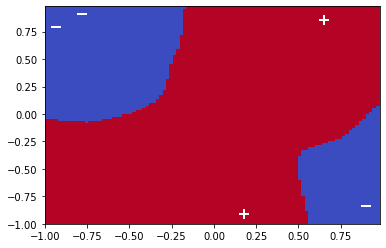

tilde_gamma=13321.159638225468, mu = 7.510609265983949, min margin = 13320.47436207247


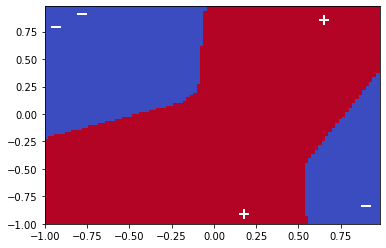

tilde_gamma=26605.42780943798, mu = 3.760511792147013, min margin = 26604.67611018396


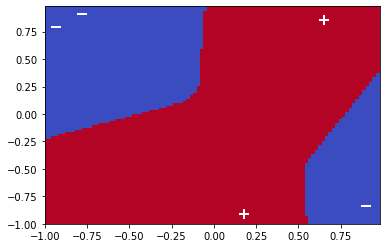

tilde_gamma=40110.20065287651, mu = 2.4943785716348064, min margin = 40109.46296618236


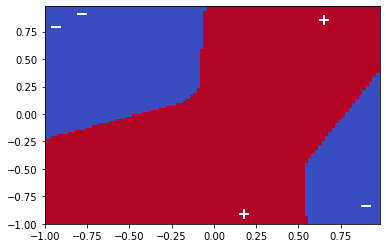

tilde_gamma=53946.87321582624, mu = 1.8546028536674524, min margin = 53946.08117351636


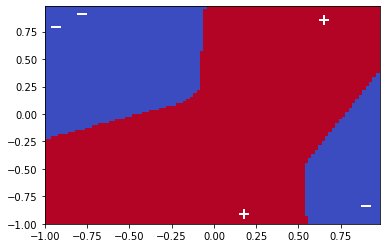

tilde_gamma=188164.4425835619, mu = 0.531715895090415, min margin = 188163.43895595998


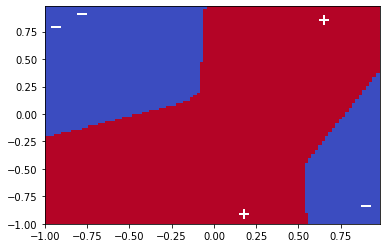

tilde_gamma=513662.121712009, mu = 0.19477789150394445, min margin = 513660.8821617889


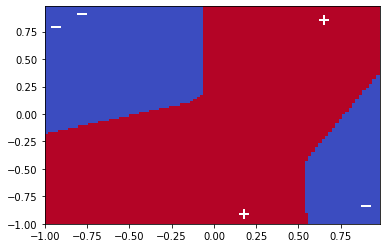

tilde_gamma=1276528.869492048, mu = 0.07837662539690086, min margin = 1276527.2745594785


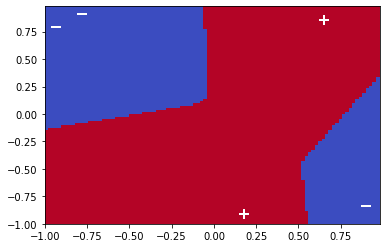

tilde_gamma=3126898.678349341, mu = 0.03199656762313866, min margin = 3126897.8835857958


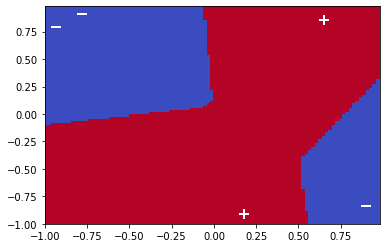

tilde_gamma=7658915.504898599, mu = 0.013063210443895896, min margin = 7658913.89546621


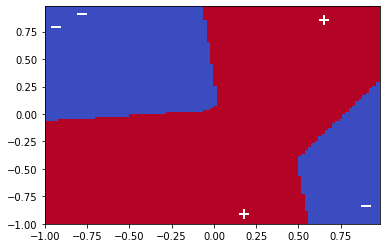

tilde_gamma=18799885.433472376, mu = 0.005321842272207302, min margin = 18799883.824034464


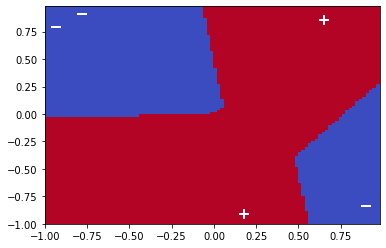

tilde_gamma=46275912.75681703, mu = 0.0021620324495440443, min margin = 46275911.14750214


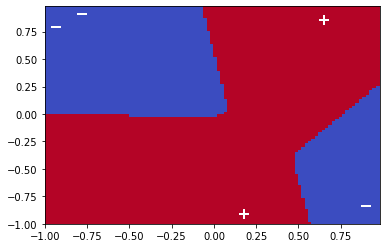

tilde_gamma=114194538.38179632, mu = 0.0008761366912137412, min margin = 114194536.77235872


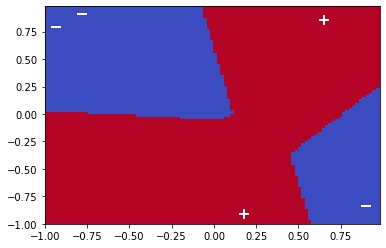

tilde_gamma=282413754.1186508, mu = 0.0003542675367378654, min margin = 282413752.5092129


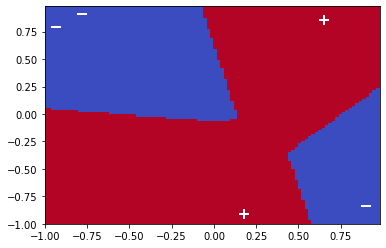

tilde_gamma=699754193.9953605, mu = 0.00014297881437659658, min margin = 699754192.3859226


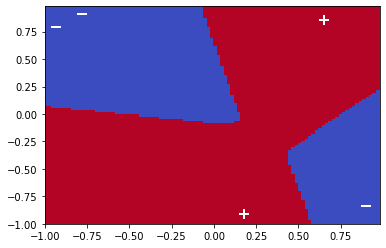

tilde_gamma=1736655989.764904, mu = 5.761073327254159e-05, min margin = 1736655988.155466


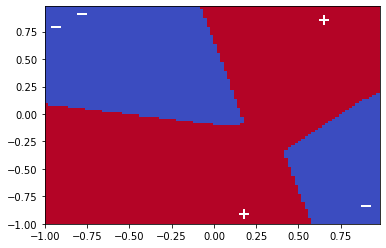

tilde_gamma=4316103039.599394, mu = 2.3180638667466547e-05, min margin = 4316103037.989956


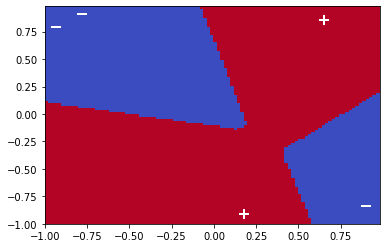

tilde_gamma=10738938810.614187, mu = 9.316565330795984e-06, min margin = 10738938809.00475


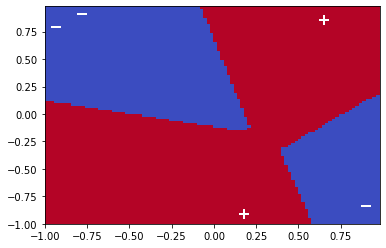

tilde_gamma=26741041693.65158, mu = 3.7414408218906382e-06, min margin = 26741041692.042145


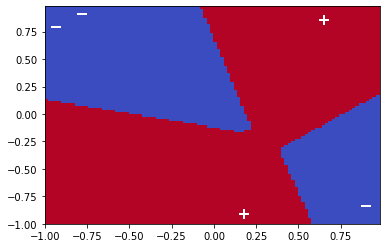

tilde_gamma=66628960527.80882, mu = 1.5015996680715118e-06, min margin = 66628960526.19939


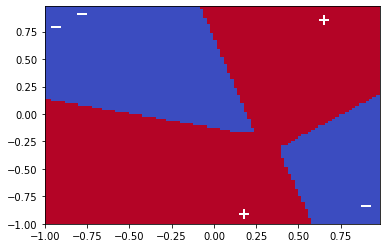

tilde_gamma=166087072447.16626, mu = 6.023950180971152e-07, min margin = 166087072445.55682


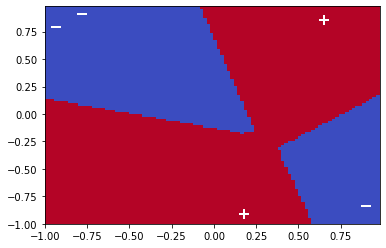

tilde_gamma=414132679040.9933, mu = 2.4158930235641716e-07, min margin = 414132679039.38385


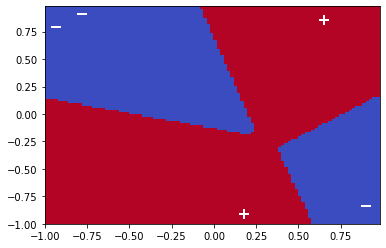

tilde_gamma=1032835490816.7786, mu = 9.686927482845003e-08, min margin = 1032835490815.1691


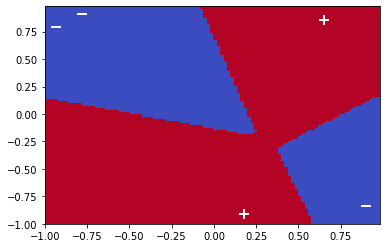

tilde_gamma=2576247104908.172, mu = 3.8835570090266554e-08, min margin = 2576247104906.5625


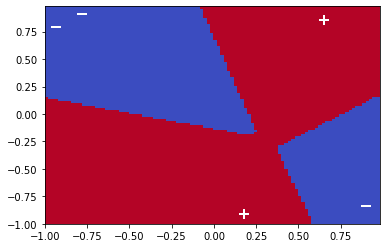

tilde_gamma=6426610138652.537, mu = 1.5568086884679924e-08, min margin = 6426610138650.928


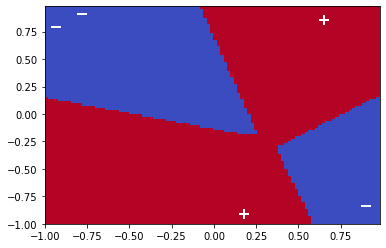

In [475]:
num_plots = 25
idx = 0
for i in range(num_plots):
    print("tilde_gamma={}, mu = {}, min margin = {}".format(
        res_GD['training_loss'][idx],
        2 * alpha[0]/(1 - s_val**2)/res_GD['training_loss'][idx], 
        minimal_margin(res_GD['w'][idx], res_GD['a'][idx], x, y)))
    plot_classifier(res_GD['w'][idx], res_GD['a'][idx], x, y)
    idx += len(res_GD['training_loss']) // num_plots    

##### NTK solution

In [476]:
clf = fit_svm_with_tangent_kernel(res_GD['w_0'], res_GD['a_0'], x, y)

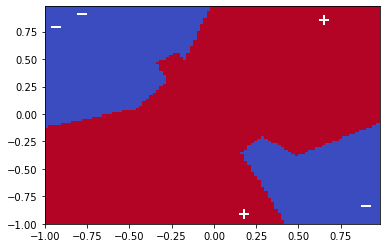

In [477]:
plot_svm_classifier(clf, x, y)

##### Show Q is a good predictor for L1 convergence

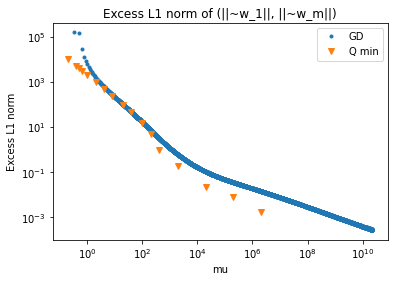

In [105]:
for s_val in [0]:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]
    
    plot(
        [t for t in res_GD['training_loss']],
        [np.linalg.norm(r, ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for r in res_GD['w_tilde_norms']],
        '.')
    
    plot(
    [(2 * alpha[0])/(1 - s_val**2)/mu_val for mu_val in res_Q['mu']],
    [np.linalg.norm(calc_w_tilde_norms(w, a), ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) 
     for w, a in zip(res_Q['w'], res_Q['a'])],
    'v')

# plot(
#     [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']],
#     [m * alpha[0]/(1 - s_val**2)/t - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for t in res_GD['training_loss']])

yscale('log')
xscale('log')
#xlim([1e-4, 1e3])
ylabel('Excess L1 norm')
xlabel('mu');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend(['GD', 'Q min', 'linear trend line']);

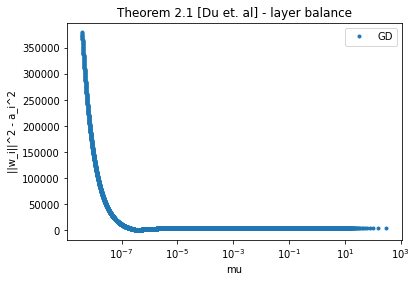

In [252]:
s_val = 0.95
res_GD = results_GD[s_val]
plot(
    [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']],
    [np.abs(np.mean(np.abs(a)**2 - np.linalg.norm(w, ord=2, axis=1)**2)) for w, a in zip(res_GD['w'], res_GD['a'])],
    '.')

xscale('log')
#yscale('log')
ylabel('||w_i||^2 - a_i^2')
xlabel('mu');
title(f'Theorem 2.1 [Du et. al] - layer balance');
legend(['GD']);

### Plot q_s

/Users/shaharazulay/Documents/work/relu-inductive-bias/source/Q_minimization.py:16: RuntimeWarning: divide by zero encountered in log
  return (x * np.log(x + np.sqrt(x**2 + s**2)) - np.sqrt(x**2 + s**2) + np.abs(s)) / 2
/Users/shaharazulay/Documents/work/relu-inductive-bias/source/Q_minimization.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return (x * np.log(x + np.sqrt(x**2 + s**2)) - np.sqrt(x**2 + s**2) + np.abs(s)) / 2


Text(0.5, 1.0, 'q_s')

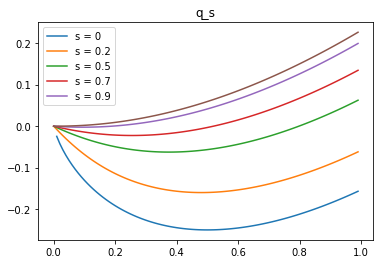

In [183]:
mu = 1
x = list(np.arange(0, mu, 0.01))
for s in [0, 0.2, 0.5, 0.7, 0.9, 0.99]:
    plot(x, list(map(lambda x: q_func(x/mu, s), x)))
    
legend([f's = {k}' for k in [0, 0.2, 0.5, 0.7, 0.9]])
title('q_s')